# Import package


In [1]:
import requests
import autograd.numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from autograd import grad, jacobian
from scipy.optimize import minimize
import datetime
from typing import List
from numba import njit
import warnings
import numpy.linalg as la

# Data import and processing


## Online

In [2]:
settledate = pd.to_datetime(datetime.date.today())
bonds = pd.DataFrame(
    json.loads(
        requests.get(
            "https://asx.api.markitdigital.com/asx-research/1.0/bonds/government/exchange-traded?height=179&width=690"
        ).content
    )["data"]["items"]
)
bonds["maturity"] = bonds["securityDescription"].str.extract(r"(\d{2}-\d{2}-\d{2})")[0]
bonds["maturity"] = pd.to_datetime(bonds["maturity"], format="%d-%m-%y")
bonds = bonds[["maturity", "couponPercent", "priceBid", "priceAsk"]]
bonds["couponPercent"] = bonds["couponPercent"].astype(float) / 100
bonds.dropna(inplace=True)
bonds.sort_values("maturity", inplace=True)
bonds.reset_index(drop=True, inplace=True)
bonds.to_csv(f"bonds_{settledate.strftime('%Y%m%d')}.csv", index=False)
bonds

,maturity,couponPercent,priceBid,priceAsk
0,2025-11-21,0.0025,98.100,99.95
1,2026-04-21,0.0425,101.000,103.00
2,2027-04-21,0.0475,102.800,103.32
3,2027-11-21,0.0275,97.400,97.97
4,2028-05-21,0.0225,96.000,96.37
5,2029-04-21,0.0325,97.000,99.82
6,2033-04-21,0.0450,101.500,104.49
7,2034-12-21,0.0350,92.700,96.83
8,2037-04-21,0.0375,93.000,94.80
9,2039-06-21,0.0325,85.750,92.40


## Offline

In [3]:
settledate = pd.to_datetime("2025-05-18")
bonds = pd.read_csv(f"bonds_{settledate.strftime('%Y%m%d')}.csv")
bonds["maturity"] = pd.to_datetime(bonds["maturity"])
bonds

,maturity,couponPercent,priceBid,priceAsk
0,2025-11-21,0.0025,98.00,99.95
1,2026-04-21,0.0425,100.81,103.00
2,2027-04-21,0.0475,102.10,103.32
3,2027-11-21,0.0275,97.50,98.22
4,2028-05-21,0.0225,96.00,96.37
5,2029-04-21,0.0325,97.00,99.82
6,2033-04-21,0.0450,101.65,103.50
7,2034-12-21,0.0350,92.70,96.83
8,2037-04-21,0.0375,93.00,93.30
9,2039-06-21,0.0325,85.75,92.00


# Support function


In [4]:
def year_transform(date: pd.Timestamp) -> float:
    """Transform date to actual year"""
    if date == settledate:
        return 0
    years = date.year - settledate.year
    check_date = pd.Timestamp(
        year=date.year,
        month=settledate.month,
        day=settledate.day,
    )
    years += (date - check_date).days / abs(
        (
            check_date
            + pd.DateOffset(years=np.sign((date - check_date).days))
            - check_date
        ).days
    )
    return years


def coupon_date_generate(maturity: pd.Timestamp) -> np.ndarray:
    """Generate coupon dates"""
    coupon_dates = [maturity]
    while maturity - pd.DateOffset(months=6) > settledate:
        maturity -= pd.DateOffset(months=6)
        coupon_dates.append(maturity)
    return np.array(list(map(year_transform, coupon_dates[::-1])))

# Discount factor curve


In [5]:
def plot(params: np.ndarray, func: callable) -> None:
    t = np.linspace(0, 30, 100000)
    dfs = func(params, t)
    plt.figure(figsize=(15, 6))
    plt.plot(t, dfs)
    plt.title("Discount Factor Curve")
    plt.xlabel("Years")
    plt.ylabel("Discount Factor")
    plt.grid()
    plt.show()

# Basic function


## Discount factor function


In [ ]:
# @njit(cache=True)
def discount_factor(params: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Calculate discount factor"""
    f0, f1, f2, gamma = params
    if gamma == 0:
        return np.exp(-f0 * t)
    if gamma < 0:
        raise ValueError("Gamma must be positive")
    res = -(
        f0 * t
        + f1 * (gamma - np.exp(-t / gamma) * gamma)
        + f2 * (gamma - np.exp(-t / gamma) * (t + gamma))
    )
    return np.exp(res)

## Bond valuation function


In [7]:
# @njit(cache=True)
def bond_valuation(params: np.ndarray, t: np.ndarray, coupon: float) -> float:
    """Calculate bond valuation"""
    cf = np.ones_like(t) * coupon / 2
    cf[-1] += 1
    return 100 * np.sum(cf * discount_factor(params, t))

## Loss function component


In [8]:
# @njit(cache=True)
def loss_function_component(
    params: np.ndarray, t: np.ndarray, coupon: float, bid: float, ask: float
) -> float:
    """Objective function for optimization"""
    bond_price = bond_valuation(params, t, coupon)
    if np.abs(bond_price) >= 1e154:
        return np.inf
    return (max(0, bond_price - ask) / ask) ** 2 + (max(0, bid - bond_price) / bid) ** 2

# Analytical


## Gradient function


In [9]:
# @njit(cache=True)
def discount_factor_gradient_analytical(
    params: np.ndarray, t: np.ndarray, element: int
) -> np.ndarray:
    """Calculate gradient of discount factor"""
    f0, f1, f2, gamma = params
    if element == 0:
        return -t * discount_factor(params, t)
    elif element == 1:
        return (-gamma + np.exp(-t / gamma) * gamma) * discount_factor(params, t)
    elif element == 2:
        return (-gamma + np.exp(-t / gamma) * (t + gamma)) * discount_factor(params, t)
    else:
        return (
            -f1 * (1 - np.exp(-t / gamma) - t * np.exp(-t / gamma) / gamma)
            - f2
            * (
                1
                - np.exp(-t / gamma)
                - t * np.exp(-t / gamma) * (t + gamma) / (gamma**2)
            )
        ) * discount_factor(params, t)


# @njit(cache=True)
def bond_valuation_gradient_analytical(
    params: np.ndarray, t: np.ndarray, coupon: float, element: int
) -> float:
    """Calculate gradient of bond valuation"""
    cf = np.ones_like(t) * coupon / 2
    cf[-1] += 1
    return 100 * np.sum(cf * discount_factor_gradient_analytical(params, t, element))


# @njit(cache=True)
def loss_function_component_gradient_analytical(
    params: np.ndarray,
    t: np.ndarray,
    coupon: float,
    bid: float,
    ask: float,
    element: int,
) -> float:
    """Calculate gradient of bond valuation"""
    vj = bond_valuation(params, t, coupon)
    if vj > ask:
        return (2 * (vj - ask) / (ask**2)) * bond_valuation_gradient_analytical(
            params, t, coupon, element
        )
    elif vj < bid:
        return (2 * (vj - bid) / (bid**2)) * bond_valuation_gradient_analytical(
            params, t, coupon, element
        )
    else:
        return 0.0

## Hessian Function


In [10]:
# @njit(cache=True)
def discount_factor_hessian_analytical(
    params: np.ndarray, t: np.ndarray, elements: List[int]
) -> np.ndarray:
    """Calculate hessian of discount factor"""
    f0, f1, f2, gamma = params
    sorted_elements = sorted(elements)
    if sorted_elements == [0, 0]:
        return t**2 * discount_factor(params, t)
    elif sorted_elements == [0, 1]:
        return -t * (-gamma + np.exp(-t / gamma) * gamma) * discount_factor(params, t)
    elif sorted_elements == [0, 2]:
        return (
            -t
            * (-gamma + np.exp(-t / gamma) * (t + gamma))
            * discount_factor(params, t)
        )
    elif sorted_elements == [0, 3]:
        return (
            -t
            * (
                -f1 * (1 - np.exp(-t / gamma) - t * np.exp(-t / gamma) / gamma)
                - f2
                * (
                    1
                    - np.exp(-t / gamma)
                    - t * np.exp(-t / gamma) * (t + gamma) / (gamma**2)
                )
            )
            * discount_factor(params, t)
        )
    elif sorted_elements == [1, 1]:
        return ((-gamma + np.exp(-t / gamma) * gamma) ** 2) * discount_factor(params, t)
    elif sorted_elements == [1, 2]:
        return (
            (-gamma + np.exp(-t / gamma) * gamma)
            * (-gamma + np.exp(-t / gamma) * (t + gamma))
            * discount_factor(params, t)
        )
    elif sorted_elements == [1, 3]:
        return (
            (-1 + np.exp(-t / gamma) + np.exp(-t / gamma) * t / gamma) * (f1 + 1)
            - f2
            * (
                1
                - np.exp(-t / gamma)
                - t * (t + gamma) * np.exp(-t / gamma) / (gamma**2)
            )
        ) * discount_factor(params, t)
    elif sorted_elements == [2, 2]:
        return ((-gamma + np.exp(-t / gamma) * (t + gamma)) ** 2) * discount_factor(
            params, t
        )
    elif sorted_elements == [2, 3]:
        return (
            (-1 + np.exp(-t / gamma) + np.exp(-t / gamma) * t / gamma)
            * (1 + f1 * (-gamma + np.exp(-t / gamma) * (t + gamma)))
            - (-gamma + np.exp(-t / gamma) * (t + gamma))
            * (
                1
                - np.exp(-t / gamma)
                - np.exp(-t / gamma) * t * (t + gamma) / (gamma**2)
            )
            * f2
        ) * discount_factor(params, t)
    else:
        return (
            np.exp(-t / gamma) * (t**2) * f1 / (gamma**3)
            - (
                -2 * np.exp(-t / gamma) * t / (gamma**2)
                - np.exp(-t / gamma) * (t**2) * (t + gamma) / (gamma**4)
                + 2 * np.exp(-t / gamma) * t
                + (t + gamma) / (gamma**3)
            )
            * f2
            + (
                f1 * (1 - np.exp(-t / gamma) - np.exp(-t / gamma) * t / gamma)
                + f2
                * (
                    1
                    - np.exp(-t / gamma)
                    - np.exp(-t / gamma) * t * (t + gamma) / (gamma**2)
                )
            )
            ** 2
        ) * discount_factor(params, t)


# @njit(cache=True)
def bond_valuation_hessian_analytical(
    params: np.ndarray, t: np.ndarray, coupon: float, elements: List[int]
) -> float:
    """Calculate hessian of bond valuation"""
    cf = np.ones_like(t) * coupon / 2
    cf[-1] += 1
    return 100 * np.sum(cf * discount_factor_hessian_analytical(params, t, elements))


# @njit(cache=True)
def loss_function_component_hessian_analytical(
    params: np.ndarray,
    t: np.ndarray,
    coupon: float,
    bid: float,
    ask: float,
    elements: List[int],
) -> float:
    """Calculate hessian of loss component"""
    vj = bond_valuation(params, t, coupon)
    if vj > ask:
        return (2 * (vj - ask) / (ask**2)) * bond_valuation_hessian_analytical(
            params, t, coupon, elements
        ) + (2 / (ask**2)) * bond_valuation_gradient_analytical(
            params, t, coupon, elements[0]
        ) * bond_valuation_gradient_analytical(
            params, t, coupon, elements[1]
        )
    elif vj < bid:
        return (2 * (vj - bid) / (bid**2)) * bond_valuation_hessian_analytical(
            params, t, coupon, elements
        ) + (2 / (bid**2)) * bond_valuation_gradient_analytical(
            params, t, coupon, elements[0]
        ) * bond_valuation_gradient_analytical(
            params, t, coupon, elements[1]
        )
    else:
        return 0.0

# Numerical


## Gradient function


In [11]:
# @njit(cache=True)
def loss_function_component_gradient_numerical(
    params: np.ndarray,
    t: np.ndarray,
    coupon: float,
    bid: float,
    ask: float,
    element: int,
    tolerance: float = 1e-15,
) -> float:
    """Calculate gradient of bond valuation"""
    param_forward = params.copy()
    param_forward[element] += tolerance
    param_backward = params.copy()
    param_backward[element] -= tolerance
    lj_forward = loss_function_component(param_forward, t, coupon, bid, ask)
    lj_backward = loss_function_component(param_backward, t, coupon, bid, ask)
    return (lj_forward - lj_backward) / (2 * tolerance)

## Hessian function


In [12]:
# @njit(cache=True)
def loss_function_component_hessian_numerical(
    params: np.ndarray,
    t: np.ndarray,
    coupon: float,
    bid: float,
    ask: float,
    elements: List[int],
    tolerance: float = 1e-15,
) -> float:
    """Calculate hessian of loss component"""
    new_elements = elements.copy()
    elements = sorted(new_elements)
    param_f_f = params.copy()
    param_f_b = params.copy()
    param_b_f = params.copy()
    param_b_b = params.copy()
    param_f_f[elements[0]] += tolerance
    param_f_f[elements[1]] += tolerance
    param_f_b[elements[0]] += tolerance
    param_f_b[elements[1]] -= tolerance
    param_b_f[elements[0]] -= tolerance
    param_b_f[elements[1]] += tolerance
    param_b_b[elements[0]] -= tolerance
    param_b_b[elements[1]] -= tolerance
    lj_f_f = loss_function_component(param_f_f, t, coupon, bid, ask)
    lj_f_b = loss_function_component(param_f_b, t, coupon, bid, ask)
    lj_b_f = loss_function_component(param_b_f, t, coupon, bid, ask)
    lj_b_b = loss_function_component(param_b_b, t, coupon, bid, ask)
    return (lj_f_f - lj_f_b - lj_b_f + lj_b_b) / (4 * tolerance**2)

# Optimizing function


In [13]:
def target(params: np.ndarray) -> float:
    """Target function to be minimized"""
    return np.sum(
        [
            loss_function_component(
                params,
                coupon_date_generate(row["maturity"]),
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )

## Library method for components


In [14]:
jac_library = grad(target)
hess_library = jacobian(grad(target))

## Analytical method for components


In [15]:
def jac_analytical(params: np.ndarray) -> np.ndarray:
    """Calculate jacobian using analytical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_gradient_analytical(
                        params,
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        element,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
        ]
    )


def hess_analytical(params: np.ndarray) -> np.ndarray:
    """Calculate hessian using analytical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_hessian_analytical(
                        params,
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        [element, element2],
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
            for element2 in range(len(params))
        ]
    ).reshape(len(params), len(params))

## Numerical method for components


In [16]:
def jac_numerical(params: np.ndarray, tolerance: float = 1e-5) -> np.ndarray:
    """Calculate jacobian using numerical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_gradient_numerical(
                        params,
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        element,
                        tolerance=tolerance,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
        ]
    )


def hess_numerical(params: np.ndarray, tolerance: float = 1e-4) -> np.ndarray:
    """Calculate hessian using numerical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_hessian_numerical(
                        params,
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        [element, element2],
                        tolerance=tolerance,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
            for element2 in range(len(params))
        ]
    ).reshape(len(params), len(params))

# Test

In [17]:
x = minimize(
    target,
    np.ones(4) * 0.415,
    bounds=[(None, None), (None, None), (None, None), (0, None)],
)

In [18]:
x.message

'CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL'

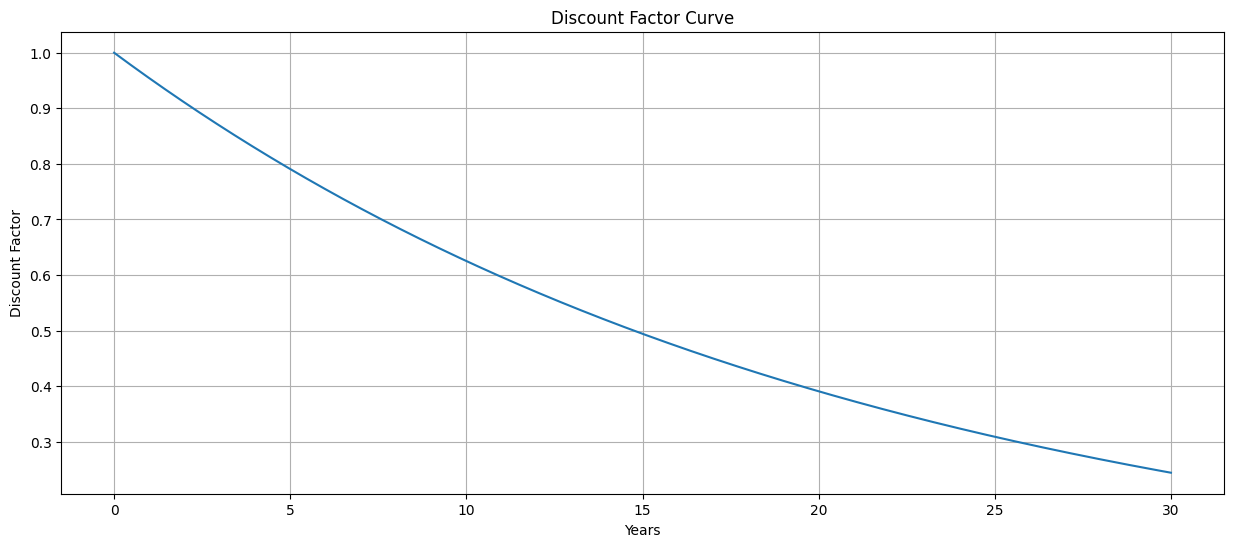

In [19]:
plot(x.x, discount_factor)

In [20]:
from optimize.steepest_descent import steepest_descent

In [21]:
def line_search(fun, jac, xk: np.ndarray, dk: np.ndarray, amax: int):
    best_alpha = 0
    best_value = fun(xk)
    for i in range(amax):
        alpha = (i + 1) / amax
        x_new = xk + alpha * dk
        if fun(x_new) < best_value:
            best_alpha = alpha
            best_value = fun(x_new)
    return best_alpha